# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

Fuente: https://github.com/Yangyangii/GAN-Tutorial


In [ ]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import os, sys

In [4]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount("/content/drive")
data_dir = '/content/drive/My Drive/CIA_marcos/deep_learning/clase_8/GANs'

Mounted at /content/drive


In [6]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784): # input_size lo elijo yo,
                                                         # es el vector de números aleatorios del cual deseo partir.
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28) # la salida le doy formato de imagen de MNIST [batchx1x28x28]
        return y_

In [9]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1): # input_size, la imagen MNIST vectorizada, num_classes=1 (REAL or FAKE)
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1) #vectorizo la imagen MNIST
        y_ = self.layer(y_)
        return y_

In [10]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE) # genero un batch de 100 vectores randn
                                            # del tamaño definido en n_noise.
    # le paso ese batch al Generador y reordeno la salida que me da.
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()

    # preparo array para guardar los 100 resultados del generador
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [11]:
# defino el tamaño del vector del ruido del cual deseo generar a imagen.
n_noise = 100

In [12]:
# instancio los modelos
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)


In [13]:
# puedo cargar un modelo ya entrenado
D.load_state_dict(torch.load(data_dir + '/vanilla_D.pkl'))

<All keys matched successfully>

In [14]:
G.load_state_dict(torch.load(data_dir + '/vanilla_G.pkl'))

<All keys matched successfully>

In [15]:
# transformación para normalizar el dataset.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [16]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 371198450.45it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108544528.52it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 189595948.04it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24518055.04it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [17]:
batch_size = 64

In [18]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [19]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [20]:
max_epoch = 100 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [21]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [22]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [25]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        # el discriminador debe ser entenado para poder reconocer imagenes
        # REAL vs FAKE

        # le paso imagenes de verdad y etiquetas de verdad.
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        # le paso imáneges falsas y etiquetas falsas.
        z = torch.randn(batch_size, n_noise).to(DEVICE) # vector randn
        fake_im = G(z) # genero con el generador
        z_outputs = D(fake_im) # las paso por el Discriminador
        D_z_loss = criterion(z_outputs, D_fakes) # comparo con etiquetas FAKE

        # perdida total discriminador
        D_loss = D_x_loss + D_z_loss # sumo ambas pérdidas

        # optimizo el Discriminador
        D.zero_grad()
        D_loss.backward()
        D_opt.step()


        if step % n_critic == 0:
            # Training Generator
            # el Generador, debe ser entrenado para engañar al Discriminador!
            # para esto, le paso imágenes falsas al Discriminaor, CON ETIQUETAS REALES!
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            # optimizo SOLO el Generador
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        # lineas plara sacar resultados parciales o imágenes parciales
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/100, Step: 0, D Loss: 1.2508105039596558, G Loss: 0.5433551669120789
Epoch: 0/100, Step: 500, D Loss: 1.155630350112915, G Loss: 0.7588426470756531
Epoch: 1/100, Step: 1000, D Loss: 1.318169116973877, G Loss: 0.9989666938781738
Epoch: 1/100, Step: 1500, D Loss: 1.2101845741271973, G Loss: 0.8996105194091797
Epoch: 2/100, Step: 2000, D Loss: 1.1395599842071533, G Loss: 0.9169061183929443
Epoch: 2/100, Step: 2500, D Loss: 1.2093737125396729, G Loss: 0.7876507043838501
Epoch: 3/100, Step: 3000, D Loss: 1.1954995393753052, G Loss: 0.9119031429290771
Epoch: 3/100, Step: 3500, D Loss: 1.2679269313812256, G Loss: 0.7525298595428467
Epoch: 4/100, Step: 4000, D Loss: 1.2144770622253418, G Loss: 0.8817201852798462
Epoch: 4/100, Step: 4500, D Loss: 1.236719012260437, G Loss: 0.801608681678772
Epoch: 5/100, Step: 5000, D Loss: 1.2021582126617432, G Loss: 0.9448027610778809
Epoch: 5/100, Step: 5500, D Loss: 1.2810288667678833, G Loss: 0.844234824180603
Epoch: 6/100, Step: 6000, D Loss: 1.2

## Visualize Sample

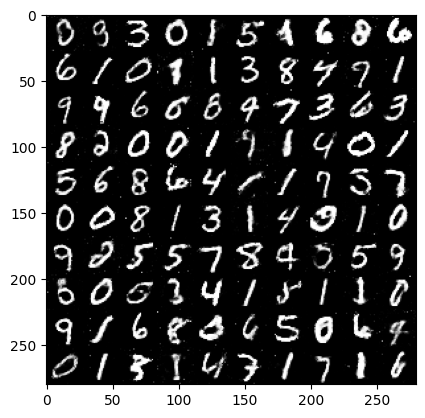

In [25]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [27]:
# Saving params.
torch.save(D.state_dict(), data_dir + '/D.pkl')
torch.save(G.state_dict(), data_dir + '/G.pkl')

In [47]:
def get_sample_image_2(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(1, n_noise).to(DEVICE) # genero un batch de 100 vectores randn
                                            # del tamaño definido en n_noise.

    z2 =  z.repeat(100, 1)
    a = torch.linspace(-1,1,100)
    z2[:,3] = a
    # le paso ese batch al Generador y reordeno la salida que me da.
    y_hat = G(z2).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()

    # preparo array para guardar los 100 resultados del generador
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

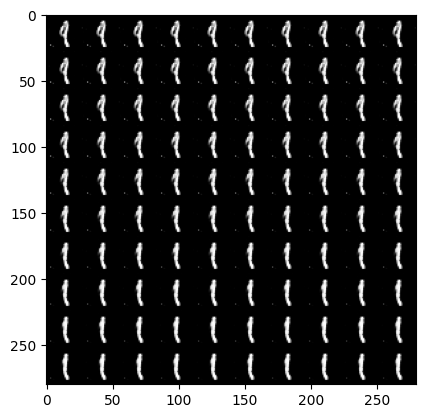

In [48]:
imshow(get_sample_image_2(G, n_noise), cmap='gray')